In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


In [50]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2020,1,1)
end = dt.datetime.now()

data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", start, end)

In [61]:
# Prepare Data
scaler = MinMaxScaler (feature_range=(0,1))
scaler_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 90
future_day=45

x_train, y_train = [], []

for x in range(prediction_days, len(scaler_data)-future_day):
    x_train.append(scaler_data[x-prediction_days:x, 0])
    y_train.append(scaler_data[x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))


In [64]:
# create neural network

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train,epochs=10,batch_size=32)


Epoch 1/10
15/15 [==============================] - 7s 158ms/step - loss: 0.0962
Epoch 2/10
15/15 [==============================] - 2s 151ms/step - loss: 0.0404
Epoch 3/10
15/15 [==============================] - 2s 151ms/step - loss: 0.0402
Epoch 4/10
15/15 [==============================] - 2s 153ms/step - loss: 0.0319
Epoch 5/10
15/15 [==============================] - 2s 151ms/step - loss: 0.0267
Epoch 6/10
15/15 [==============================] - 2s 151ms/step - loss: 0.0218
Epoch 7/10
15/15 [==============================] - 2s 154ms/step - loss: 0.0133
Epoch 8/10
15/15 [==============================] - 2s 156ms/step - loss: 0.0084
Epoch 9/10
15/15 [==============================] - 2s 153ms/step - loss: 0.0084
Epoch 10/10
15/15 [==============================] - 2s 153ms/step - loss: 0.0098


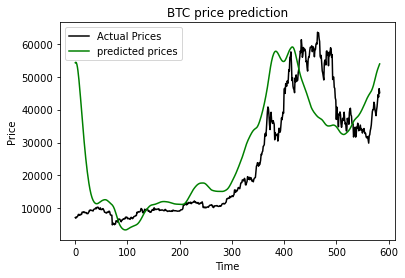

In [65]:
# Testing the Model

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(f"{crypto_currency}-{against_currency}", "yahoo", test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices,color='green', label='predicted prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()